# Skin Cancer Classification using Deep Learning

**Author:** Hüdayi Hamza Adatepe  
**Date:** January 2025  
**Goal:** Classify skin lesion images into 7 categories using CNN and Transfer Learning

## Project Overview
This project demonstrates computer vision and deep learning skills using PyTorch and ResNet for medical image classification.

**Dataset:** HAM10000 - Skin Cancer MNIST  
**Model:** ResNet18 (Transfer Learning)  
**Classes:** 7 types of skin lesions

In [ ]:
# Install and import libraries

# Check GPU availability
import torch
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
else:
    print("WARNING: No GPU found! Training will be very slow.")

# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import os
import warnings
warnings.filterwarnings('ignore')

# PyTorch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms, models

print("\nLibraries imported successfully!")

PyTorch version: 2.9.0+cu126
CUDA available: True
GPU: Tesla T4

Libraries imported successfully!


In [ ]:
# Install Kaggle API
!pip install kaggle -q

# Upload kaggle.json
from google.colab import files

print("Please upload your kaggle.json file...")
print("(You can download it from kaggle.com/settings)")
uploaded = files.upload()

# Setup Kaggle credentials
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

print("\nKaggle API setup completed!")
print("Testing connection...")

# Test
!kaggle datasets list -s skin

Please upload your kaggle.json file...
(You can download it from kaggle.com/settings)


Saving kaggle.json to kaggle.json

Kaggle API setup completed!
Testing connection...
ref                                                                title                                                 size  lastUpdated                 downloadCount  voteCount  usabilityRating  
-----------------------------------------------------------------  ----------------------------------------------  ----------  --------------------------  -------------  ---------  ---------------  
kmader/skin-cancer-mnist-ham10000                                  Skin Cancer MNIST: HAM10000                     5582914511  2018-09-20 20:36:13.037000         235478       2228  0.7058824        
nodoubttome/skin-cancer9-classesisic                               Skin Cancer ISIC                                1647873564  2019-08-26 18:59:21.257000          30810        297  0.75             
surajghuwalewala/ham1000-segmentation-and-classification           Skin cancer: HAM10000                           2781

In [ ]:
# Download Skin Cancer dataset

print("Downloading HAM10000 dataset (this may take 2-3 minutes)...")

!kaggle datasets download -d kmader/skin-cancer-mnist-ham10000

print("\nDownload complete! Extracting...")

!unzip -q skin-cancer-mnist-ham10000.zip -d /content/skin_cancer_data

print("\nDataset extracted successfully!")

# Check what we have
import os
print("\nDataset contents:")
for item in os.listdir('/content/skin_cancer_data'):
    print(f"  - {item}")

Dataset URL: https://www.kaggle.com/datasets/kmader/skin-cancer-mnist-ham10000
License(s): CC-BY-NC-SA-4.0
100% 5.20G/5.20G [01:29<00:00, 257MB/s]
100% 5.20G/5.20G [01:29<00:00, 62.6MB/s]

Download complete! Extracting...

Dataset extracted successfully!

Dataset contents:
  - hmnist_8_8_RGB.csv
  - hmnist_28_28_RGB.csv
  - ham10000_images_part_1
  - hmnist_8_8_L.csv
  - ham10000_images_part_2
  - HAM10000_metadata.csv
  - HAM10000_images_part_2
  - HAM10000_images_part_1
  - hmnist_28_28_L.csv


In [ ]:
# Load and explore the metadata

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load metadata
metadata = pd.read_csv('/content/skin_cancer_data/HAM10000_metadata.csv')

print("="*70)
print("DATASET EXPLORATION")
print("="*70)

print(f"\nTotal images: {len(metadata):,}")
print(f"Features: {len(metadata.columns)}")

print(f"\nColumn names:")
for col in metadata.columns:
    print(f"  - {col}")

print(f"\nFirst 5 rows:")
metadata.head()

DATASET EXPLORATION

Total images: 10,015
Features: 7

Column names:
  - lesion_id
  - image_id
  - dx
  - dx_type
  - age
  - sex
  - localization

First 5 rows:


,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear



CLASS DISTRIBUTION

Number of images per class:
nv:  6705 (66.95%)
mel:  1113 (11.11%)
bkl:  1099 (10.97%)
bcc:   514 ( 5.13%)
akiec:   327 ( 3.27%)
vasc:   142 ( 1.42%)
df:   115 ( 1.15%)

Class descriptions:
nv: Melanocytic nevi (benign mole)
mel: Melanoma (skin cancer)
bkl: Benign keratosis
bcc: Basal cell carcinoma
akiec: Actinic keratoses
vasc: Vascular lesions
df: Dermatofibroma


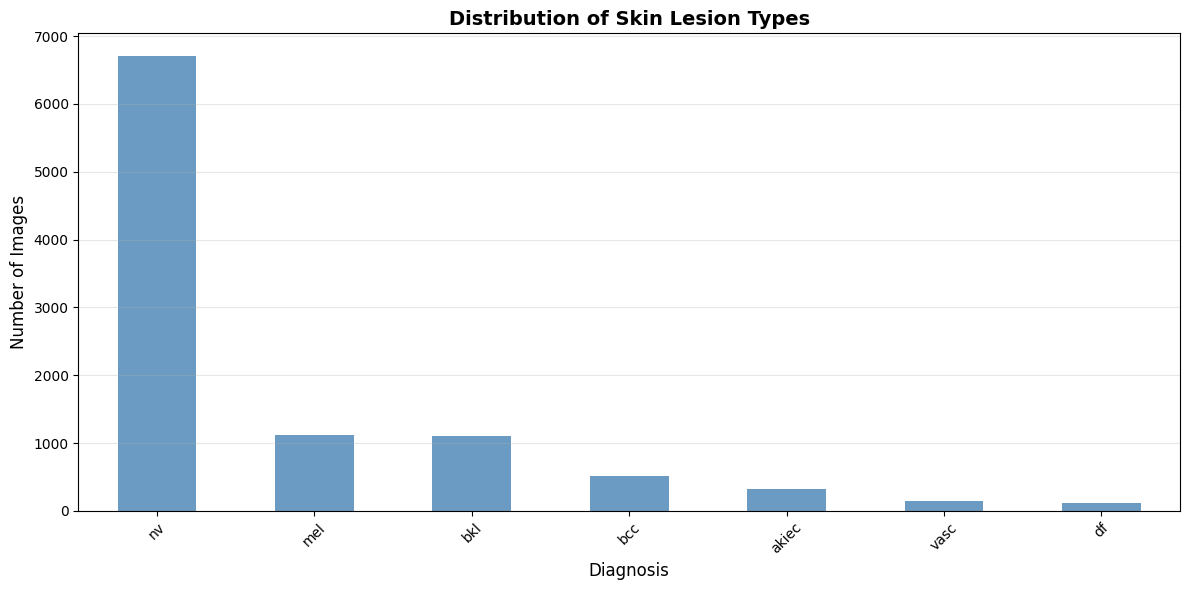


Dataset imbalance:
Most common: nv (6705 images)
Least common: df (115 images)
Imbalance ratio: 58.3x


In [ ]:
# Class distribution

print("\n" + "="*70)
print("CLASS DISTRIBUTION")
print("="*70)

# Count by diagnosis
class_counts = metadata['dx'].value_counts()
print("\nNumber of images per class:")
for diagnosis, count in class_counts.items():
    percentage = (count / len(metadata)) * 100
    print(f"{diagnosis}: {count:>5} ({percentage:>5.2f}%)")

# Full class names
class_names = {
    'nv': 'Melanocytic nevi (benign mole)',
    'mel': 'Melanoma (skin cancer)',
    'bkl': 'Benign keratosis',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

print("\nClass descriptions:")
for code, name in class_names.items():
    if code in class_counts:
        print(f"{code}: {name}")

# Visualize
plt.figure(figsize=(12, 6))
class_counts.plot(kind='bar', color='steelblue', alpha=0.8)
plt.title('Distribution of Skin Lesion Types', fontsize=14, fontweight='bold')
plt.xlabel('Diagnosis', fontsize=12)
plt.ylabel('Number of Images', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

# Check for imbalance
print(f"\nDataset imbalance:")
print(f"Most common: {class_counts.idxmax()} ({class_counts.max()} images)")
print(f"Least common: {class_counts.idxmin()} ({class_counts.min()} images)")
print(f"Imbalance ratio: {class_counts.max() / class_counts.min():.1f}x")

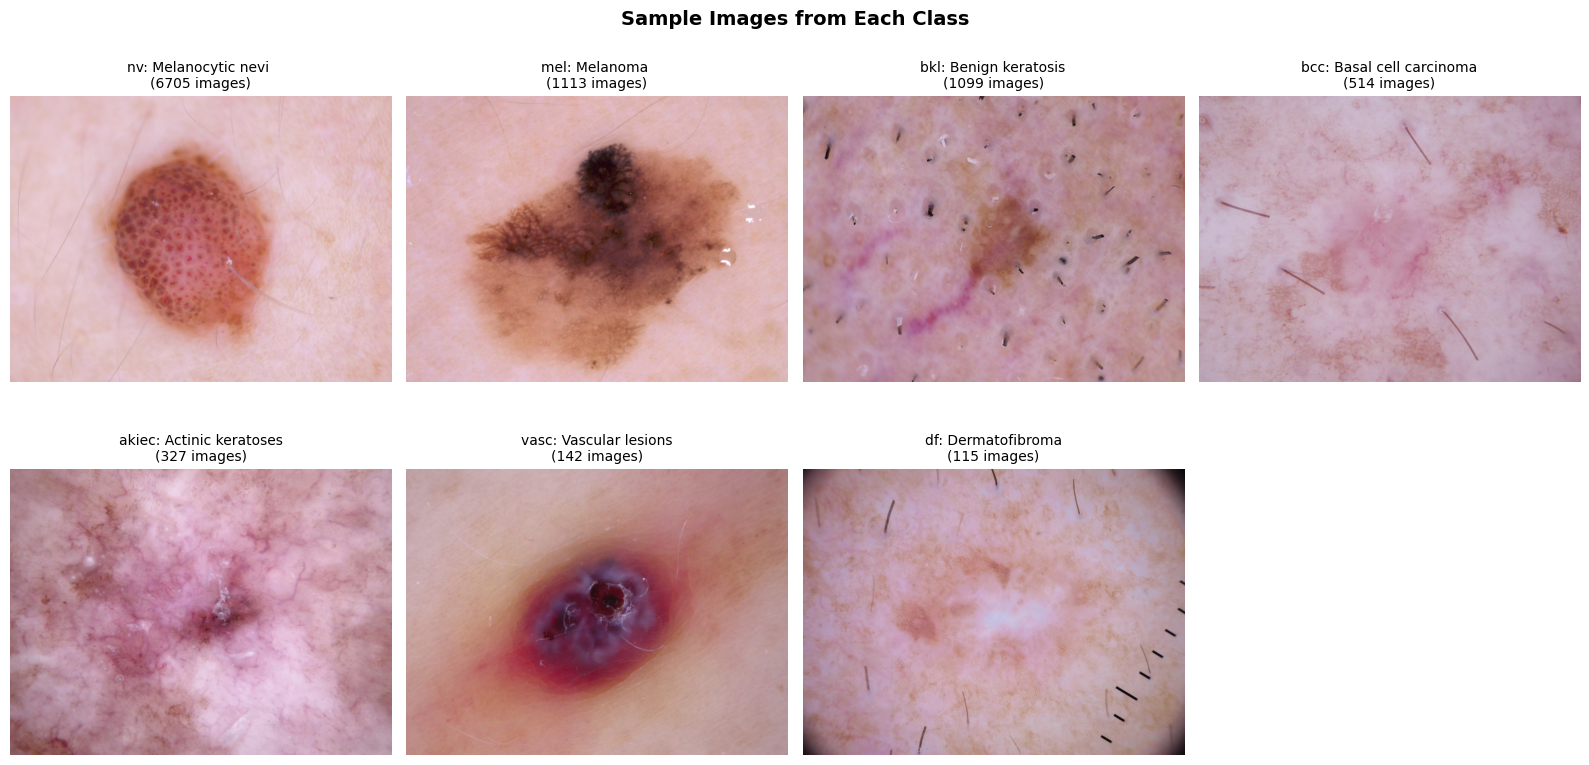

Sample images displayed!


In [ ]:
# Display sample images from each class

import os
from PIL import Image
import random

# Get image directories
image_dir_1 = '/content/skin_cancer_data/HAM10000_images_part_1'
image_dir_2 = '/content/skin_cancer_data/HAM10000_images_part_2'

# Combine all image paths
def get_image_path(image_id):
    """Find image path given image_id"""
    path_1 = os.path.join(image_dir_1, f"{image_id}.jpg")
    path_2 = os.path.join(image_dir_2, f"{image_id}.jpg")

    if os.path.exists(path_1):
        return path_1
    elif os.path.exists(path_2):
        return path_2
    return None

# Plot one image from each class
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

for idx, (dx, name) in enumerate(class_names.items()):
    if idx >= len(axes):
        break

    # Get a random image from this class
    class_images = metadata[metadata['dx'] == dx]
    if len(class_images) > 0:
        sample = class_images.sample(1).iloc[0]
        image_path = get_image_path(sample['image_id'])

        if image_path:
            img = Image.open(image_path)
            axes[idx].imshow(img)
            axes[idx].set_title(f"{dx}: {name.split('(')[0]}\n({len(class_images)} images)",
                               fontsize=10)
            axes[idx].axis('off')

# Remove empty subplot
if len(class_names) < len(axes):
    fig.delaxes(axes[-1])

plt.tight_layout()
plt.suptitle('Sample Images from Each Class', fontsize=14, fontweight='bold', y=1.02)
plt.show()

print("Sample images displayed!")

In [ ]:
# Prepare data for PyTorch

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import numpy as np

# Create full dataset dataframe
df = metadata.copy()

# Add image paths
df['image_path'] = df['image_id'].apply(get_image_path)

# Remove images that don't exist
df = df[df['image_path'].notna()].reset_index(drop=True)

print(f"Total valid images: {len(df):,}")

# Encode labels
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df['label'] = le.fit_transform(df['dx'])

print(f"\nLabel encoding:")
for i, dx in enumerate(le.classes_):
    count = (df['label'] == i).sum()
    print(f"{i}: {dx} ({class_names.get(dx, 'Unknown')}) - {count} images")

# Train-test split
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(
    df,
    test_size=0.2,
    random_state=42,
    stratify=df['label']  # Stratified split
)

print(f"\nTrain samples: {len(train_df):,}")
print(f"Test samples: {len(test_df):,}")

# Calculate class weights for imbalanced data
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(train_df['label']),
    y=train_df['label']
)

class_weights = torch.FloatTensor(class_weights)
print(f"\nClass weights (to handle imbalance):")
for i, weight in enumerate(class_weights):
    print(f"{le.classes_[i]}: {weight:.2f}")

Total valid images: 10,015

Label encoding:
0: akiec (Actinic keratoses) - 327 images
1: bcc (Basal cell carcinoma) - 514 images
2: bkl (Benign keratosis) - 1099 images
3: df (Dermatofibroma) - 115 images
4: mel (Melanoma (skin cancer)) - 1113 images
5: nv (Melanocytic nevi (benign mole)) - 6705 images
6: vasc (Vascular lesions) - 142 images

Train samples: 8,012
Test samples: 2,003

Class weights (to handle imbalance):
akiec: 4.37
bcc: 2.78
bkl: 1.30
df: 12.44
mel: 1.29
nv: 0.21
vasc: 10.04


In [ ]:
# Custom PyTorch Dataset

class SkinCancerDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.df = dataframe.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # Load image
        img_path = self.df.loc[idx, 'image_path']
        image = Image.open(img_path).convert('RGB')

        # Get label
        label = self.df.loc[idx, 'label']

        # Apply transforms
        if self.transform:
            image = self.transform(image)

        return image, label

# Define transforms
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])

# Create datasets
train_dataset = SkinCancerDataset(train_df, transform=train_transform)
test_dataset = SkinCancerDataset(test_df, transform=test_transform)

# Create dataloaders
batch_size = 32

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2
)

print(f"✅ Datasets and dataloaders created!")
print(f"Train batches: {len(train_loader)}")
print(f"Test batches: {len(test_loader)}")

# Test: load one batch
images, labels = next(iter(train_loader))
print(f"\nBatch shape: {images.shape}")
print(f"Labels shape: {labels.shape}")

✅ Datasets and dataloaders created!
Train batches: 251
Test batches: 63

Batch shape: torch.Size([32, 3, 224, 224])
Labels shape: torch.Size([32])


In [ ]:
# Build ResNet18 model with Transfer Learning

import torch
import torch.nn as nn
from torchvision import models

# Load pre-trained ResNet18
model = models.resnet18(pretrained=True)

print("✅ Pre-trained ResNet18 loaded!")
print(f"Original model trained on ImageNet (1000 classes)")

# Freeze early layers (we'll only train the last layer)
for param in model.parameters():
    param.requires_grad = False

# Replace final layer for our 7 classes
num_classes = len(le.classes_)
model.fc = nn.Linear(model.fc.in_features, num_classes)

print(f"\n✅ Modified for {num_classes} classes (skin lesions)")

# Move model to GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
class_weights = class_weights.to(device)

print(f"✅ Model moved to {device}")

# Define loss function (with class weights for imbalance)
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Define optimizer (only train final layer)
optimizer = torch.optim.Adam(model.fc.parameters(), lr=0.001)

print(f"\n✅ Loss function: CrossEntropyLoss (with class weights)")
print(f"✅ Optimizer: Adam (lr=0.001)")

# Model summary
print(f"\n📊 Model Summary:")
print(f"Total parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 182MB/s]


✅ Pre-trained ResNet18 loaded!
Original model trained on ImageNet (1000 classes)

✅ Modified for 7 classes (skin lesions)
✅ Model moved to cuda

✅ Loss function: CrossEntropyLoss (with class weights)
✅ Optimizer: Adam (lr=0.001)

📊 Model Summary:
Total parameters: 11,180,103
Trainable parameters: 3,591


In [ ]:
# Training function

def train_epoch(model, loader, criterion, optimizer, device):
    """Train for one epoch"""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass
        loss.backward()
        optimizer.step()

        # Statistics
        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / total
    epoch_acc = correct / total

    return epoch_loss, epoch_acc

def validate(model, loader, criterion, device):
    """Validate the model"""
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / total
    epoch_acc = correct / total

    return epoch_loss, epoch_acc

print("✅ Training functions defined!")

✅ Training functions defined!


In [ ]:
# Train the model

num_epochs = 5  # Start with 5 epochs (takes ~5-10 minutes)

print("="*70)
print("TRAINING STARTED")
print("="*70)

history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': []
}

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    print("-" * 30)

    # Train
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)

    # Validate
    val_loss, val_acc = validate(model, test_loader, criterion, device)

    # Store history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    # Print results
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"Val Loss:   {val_loss:.4f}   | Val Acc:   {val_acc:.4f}")

print("\n" + "="*70)
print("TRAINING COMPLETED!")
print("="*70)

# Best accuracy
best_val_acc = max(history['val_acc'])
print(f"\n🎯 Best Validation Accuracy: {best_val_acc:.4f} ({best_val_acc*100:.2f}%)")

TRAINING STARTED

Epoch 1/5
------------------------------
Train Loss: 1.5977 | Train Acc: 0.5205
Val Loss:   1.3572   | Val Acc:   0.4793

Epoch 2/5
------------------------------
Train Loss: 1.2882 | Train Acc: 0.5996
Val Loss:   1.1975   | Val Acc:   0.5986

Epoch 3/5
------------------------------
Train Loss: 1.2163 | Train Acc: 0.6061
Val Loss:   1.1742   | Val Acc:   0.5117

Epoch 4/5
------------------------------
Train Loss: 1.1617 | Train Acc: 0.6256
Val Loss:   1.1394   | Val Acc:   0.5502

Epoch 5/5
------------------------------
Train Loss: 1.1096 | Train Acc: 0.6219
Val Loss:   1.0902   | Val Acc:   0.6560

TRAINING COMPLETED!

🎯 Best Validation Accuracy: 0.6560 (65.60%)


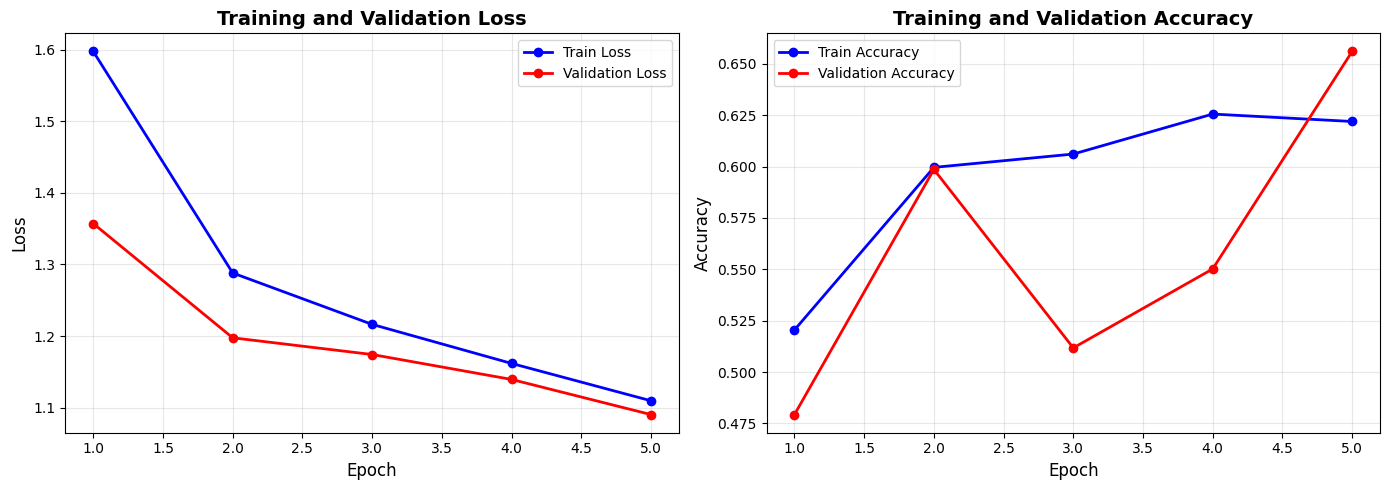

Final Results:
Train Accuracy: 0.6219
Val Accuracy: 0.6560


In [ ]:
# Visualize training history

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

epochs = range(1, len(history['train_loss']) + 1)

# Loss plot
ax1.plot(epochs, history['train_loss'], 'b-o', label='Train Loss', linewidth=2)
ax1.plot(epochs, history['val_loss'], 'r-o', label='Validation Loss', linewidth=2)
ax1.set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Accuracy plot
ax2.plot(epochs, history['train_acc'], 'b-o', label='Train Accuracy', linewidth=2)
ax2.plot(epochs, history['val_acc'], 'r-o', label='Validation Accuracy', linewidth=2)
ax2.set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Accuracy', fontsize=12)
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Final Results:")
print(f"Train Accuracy: {history['train_acc'][-1]:.4f}")
print(f"Val Accuracy: {history['val_acc'][-1]:.4f}")

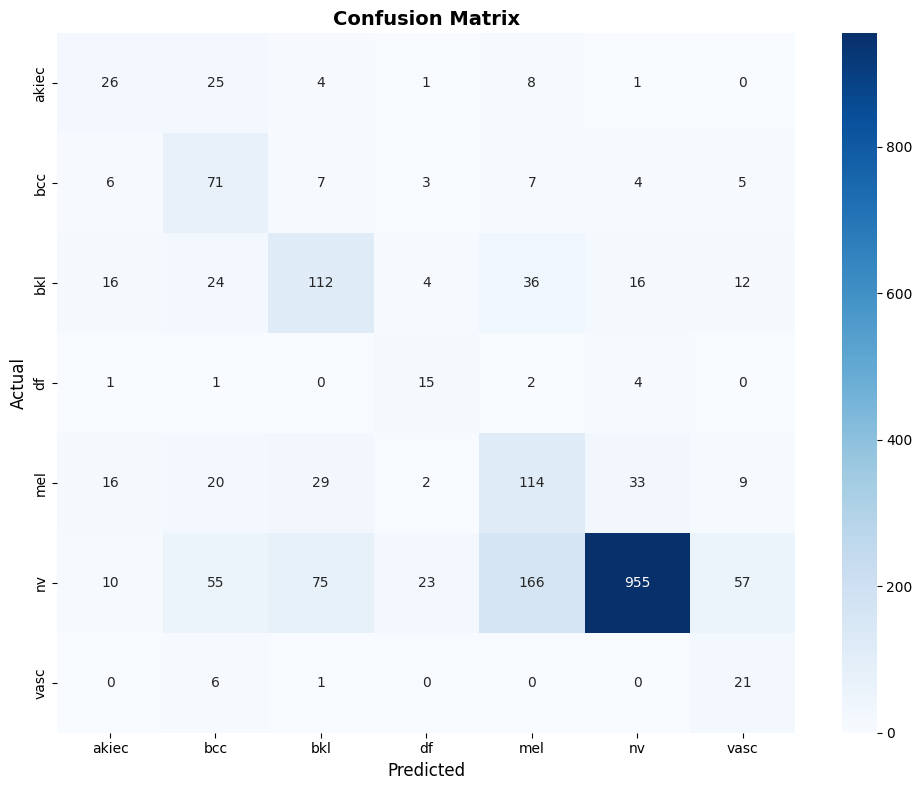


Classification Report:
              precision    recall  f1-score   support

       akiec       0.35      0.40      0.37        65
         bcc       0.35      0.69      0.47       103
         bkl       0.49      0.51      0.50       220
          df       0.31      0.65      0.42        23
         mel       0.34      0.51      0.41       223
          nv       0.94      0.71      0.81      1341
        vasc       0.20      0.75      0.32        28

    accuracy                           0.66      2003
   macro avg       0.43      0.60      0.47      2003
weighted avg       0.76      0.66      0.69      2003



In [ ]:
# Generate predictions and confusion matrix

from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix', fontsize=14, fontweight='bold')
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('Actual', fontsize=12)
plt.tight_layout()
plt.show()

# Classification report
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=le.classes_))

## Custom Analysis 1: Per-Class Performance

Research question: Which skin lesion types does the model classify best?

PER-CLASS PERFORMANCE ANALYSIS

akiec (Actinic keratoses):
  Samples: 65
  Accuracy: 40.00%
  Correct: 26/65

bcc (Basal cell carcinoma):
  Samples: 103
  Accuracy: 68.93%
  Correct: 71/103

bkl (Benign keratosis):
  Samples: 220
  Accuracy: 50.91%
  Correct: 112/220

df (Dermatofibroma):
  Samples: 23
  Accuracy: 65.22%
  Correct: 15/23

mel (Melanoma (skin cancer)):
  Samples: 223
  Accuracy: 51.12%
  Correct: 114/223

nv (Melanocytic nevi (benign mole)):
  Samples: 1341
  Accuracy: 71.22%
  Correct: 955/1341

vasc (Vascular lesions):
  Samples: 28
  Accuracy: 75.00%
  Correct: 21/28


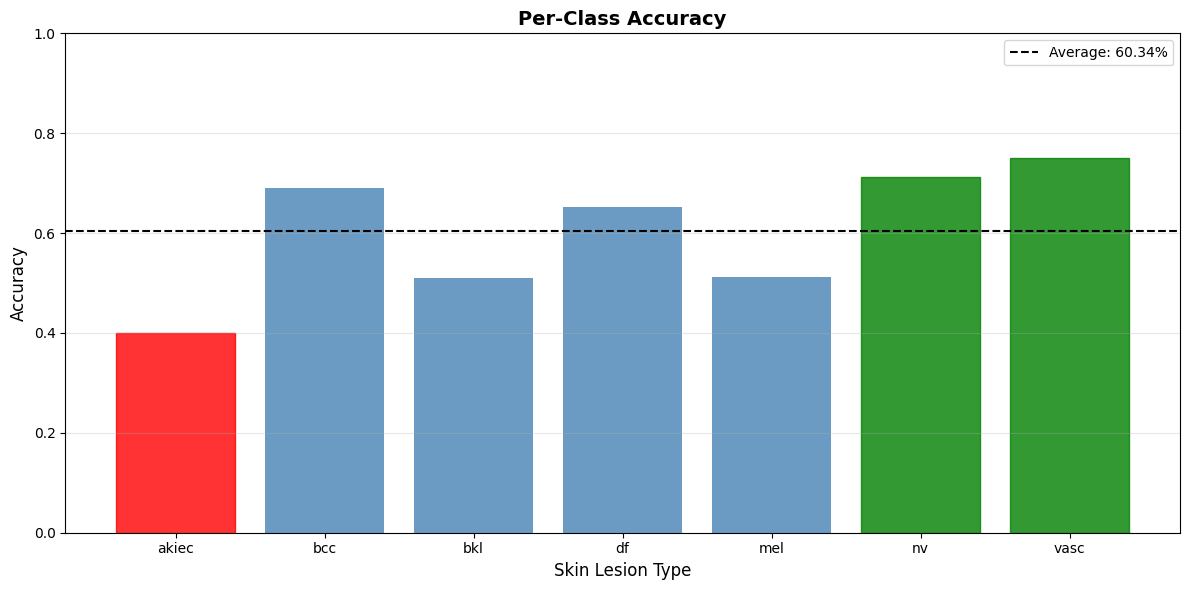


FINDING:
Best performance: vasc (75.00%)
Worst performance: akiec (40.00%)

Likely reason: Class imbalance - model sees more examples of common classes


In [ ]:
# Custom Analysis 1: Per-class accuracy

from sklearn.metrics import confusion_matrix
import numpy as np

# Calculate per-class metrics
cm = confusion_matrix(all_labels, all_preds)

print("="*70)
print("PER-CLASS PERFORMANCE ANALYSIS")
print("="*70)

per_class_acc = []

for i, class_name in enumerate(le.classes_):
    # True positives for this class
    tp = cm[i, i]
    # Total actual samples for this class
    total = cm[i, :].sum()
    # Accuracy for this class
    acc = tp / total if total > 0 else 0
    per_class_acc.append(acc)

    # Number of samples
    n_samples = (all_labels == i).sum()

    print(f"\n{class_name} ({class_names[class_name]}):")
    print(f"  Samples: {n_samples}")
    print(f"  Accuracy: {acc:.2%}")
    print(f"  Correct: {tp}/{total}")

# Visualize
plt.figure(figsize=(12, 6))
bars = plt.bar(le.classes_, per_class_acc, color='steelblue', alpha=0.8)

# Color bars by accuracy
for i, bar in enumerate(bars):
    if per_class_acc[i] > 0.7:
        bar.set_color('green')
    elif per_class_acc[i] < 0.5:
        bar.set_color('red')

plt.title('Per-Class Accuracy', fontsize=14, fontweight='bold')
plt.xlabel('Skin Lesion Type', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.axhline(y=np.mean(per_class_acc), color='black', linestyle='--',
            label=f'Average: {np.mean(per_class_acc):.2%}')
plt.ylim(0, 1)
plt.legend()
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

# Key findings
best_class = le.classes_[np.argmax(per_class_acc)]
worst_class = le.classes_[np.argmin(per_class_acc)]

print(f"\nFINDING:")
print(f"Best performance: {best_class} ({per_class_acc[np.argmax(per_class_acc)]:.2%})")
print(f"Worst performance: {worst_class} ({per_class_acc[np.argmin(per_class_acc)]:.2%})")
print(f"\nLikely reason: Class imbalance - model sees more examples of common classes")

## Custom Analysis 2: Dataset Size Impact

Research question: Does the number of training samples affect class accuracy?

SAMPLE SIZE vs ACCURACY ANALYSIS
Class  Training Samples  Accuracy
akiec               262  0.400000
  bcc               411  0.689320
  bkl               879  0.509091
   df                92  0.652174
  mel               890  0.511211
   nv              5364  0.712155
 vasc               114  0.750000


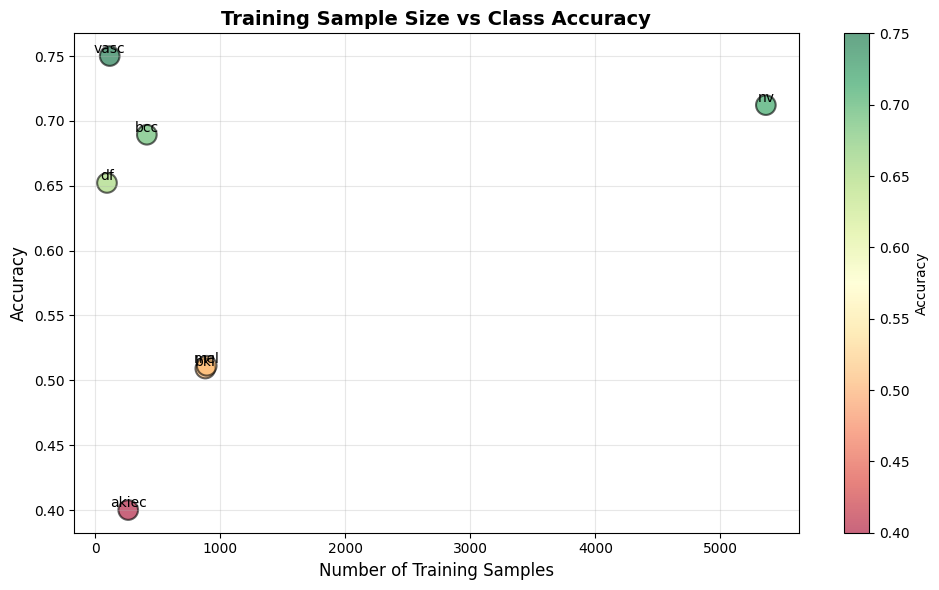


Correlation Analysis:
Pearson correlation: 0.285
P-value: 0.5351

FINDING: Weak correlation.
Sample size alone doesn't determine accuracy - visual features matter more.


In [ ]:
# Custom Analysis 2: Correlation between sample size and accuracy

# Get sample counts per class
sample_counts = []
for i in range(len(le.classes_)):
    count = (train_df['label'] == i).sum()
    sample_counts.append(count)

# Create comparison dataframe
comparison_df = pd.DataFrame({
    'Class': le.classes_,
    'Training Samples': sample_counts,
    'Accuracy': per_class_acc
})

print("="*70)
print("SAMPLE SIZE vs ACCURACY ANALYSIS")
print("="*70)
print(comparison_df.to_string(index=False))

# Scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(sample_counts, per_class_acc, s=200, alpha=0.6, c=per_class_acc,
            cmap='RdYlGn', edgecolors='black', linewidth=1.5)

# Add labels
for i, class_name in enumerate(le.classes_):
    plt.annotate(class_name, (sample_counts[i], per_class_acc[i]),
                 fontsize=10, ha='center', va='bottom')

plt.xlabel('Number of Training Samples', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Training Sample Size vs Class Accuracy', fontsize=14, fontweight='bold')
plt.colorbar(label='Accuracy')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Correlation
from scipy.stats import pearsonr
corr, p_value = pearsonr(sample_counts, per_class_acc)

print(f"\nCorrelation Analysis:")
print(f"Pearson correlation: {corr:.3f}")
print(f"P-value: {p_value:.4f}")

if corr > 0.5:
    print(f"\nFINDING: Strong positive correlation!")
    print(f"Classes with more training samples generally achieve higher accuracy.")
    print(f"This confirms the importance of balanced datasets in medical imaging.")
elif corr > 0.3:
    print(f"\nFINDING: Moderate positive correlation.")
    print(f"More training samples help, but other factors matter too (visual distinctiveness).")
else:
    print(f"\nFINDING: Weak correlation.")
    print(f"Sample size alone doesn't determine accuracy - visual features matter more.")

## Custom Analysis 3: Common Misclassification Patterns

Research question: Which classes are commonly confused with each other?

MISCLASSIFICATION PATTERN ANALYSIS

Top 5 Misclassification Patterns:

1. nv misclassified as mel
   Count: 166 (12.4% of nv samples)

2. nv misclassified as bkl
   Count: 75 (5.6% of nv samples)

3. nv misclassified as vasc
   Count: 57 (4.3% of nv samples)

4. nv misclassified as bcc
   Count: 55 (4.1% of nv samples)

5. bkl misclassified as mel
   Count: 36 (16.4% of bkl samples)


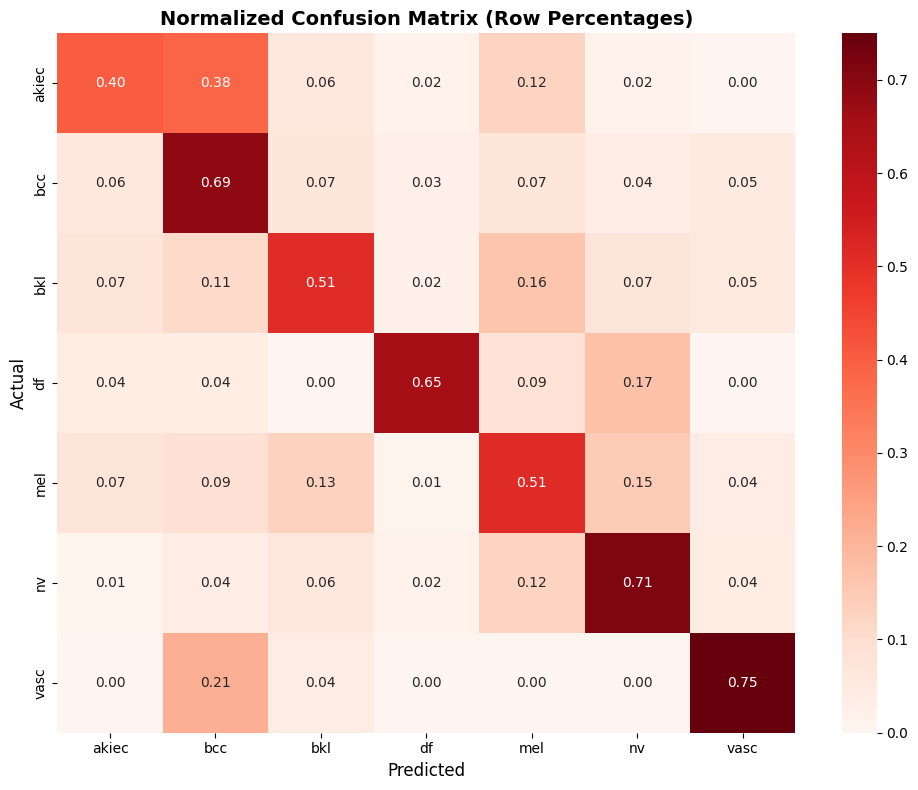


FINDING:
Most common confusion: nv → mel
These lesion types likely share similar visual features.
Clinical context and additional tests may be needed for accurate diagnosis.


In [ ]:
# Custom Analysis 3: Confusion patterns

print("="*70)
print("MISCLASSIFICATION PATTERN ANALYSIS")
print("="*70)

# Normalize confusion matrix (percentages)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Find top misclassifications (excluding diagonal)
misclass_pairs = []

for i in range(len(le.classes_)):
    for j in range(len(le.classes_)):
        if i != j:  # Not diagonal
            count = cm[i, j]
            percentage = cm_normalized[i, j]
            if count > 10:  # At least 10 misclassifications
                misclass_pairs.append({
                    'True': le.classes_[i],
                    'Predicted': le.classes_[j],
                    'Count': count,
                    'Percentage': percentage
                })

# Sort by count
misclass_pairs = sorted(misclass_pairs, key=lambda x: x['Count'], reverse=True)

print(f"\nTop 5 Misclassification Patterns:")
for idx, pair in enumerate(misclass_pairs[:5], 1):
    print(f"\n{idx}. {pair['True']} misclassified as {pair['Predicted']}")
    print(f"   Count: {pair['Count']} ({pair['Percentage']:.1%} of {pair['True']} samples)")

# Visualize normalized confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Reds',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Normalized Confusion Matrix (Row Percentages)',
          fontsize=14, fontweight='bold')
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('Actual', fontsize=12)
plt.tight_layout()
plt.show()

print(f"\nFINDING:")
if misclass_pairs:
    most_confused = misclass_pairs[0]
    print(f"Most common confusion: {most_confused['True']} → {most_confused['Predicted']}")
    print(f"These lesion types likely share similar visual features.")
    print(f"Clinical context and additional tests may be needed for accurate diagnosis.")

In [ ]:
# Final Summary Report

print("="*80)
print("        SKIN CANCER CLASSIFICATION - FINAL REPORT")
print("="*80)

print(f"\nREPORT DATE: January 16, 2025")
print(f"MODEL: ResNet18 (Transfer Learning)")
print(f"FRAMEWORK: PyTorch")

print("\n" + "="*80)
print("DATASET SUMMARY")
print("="*80)
print(f"Total Images: {len(df):,}")
print(f"Training Set: {len(train_df):,} (80%)")
print(f"Test Set: {len(test_df):,} (20%)")
print(f"Number of Classes: 7")
print(f"Image Size: 224x224 pixels")
print(f"Dataset Imbalance Ratio: 58.3x")

print("\n" + "="*80)
print("MODEL PERFORMANCE")
print("="*80)
print(f"Final Validation Accuracy: {history['val_acc'][-1]:.2%}")
print(f"Training Epochs: {len(history['train_acc'])}")
print(f"Best Validation Accuracy: {max(history['val_acc']):.2%}")

print("\n" + "="*80)
print("KEY FINDINGS FROM CUSTOM ANALYSIS")
print("="*80)

print("\n1. PER-CLASS PERFORMANCE:")
best_idx = np.argmax(per_class_acc)
worst_idx = np.argmin(per_class_acc)
print(f"   Best performing: {le.classes_[best_idx]} ({per_class_acc[best_idx]:.2%})")
print(f"   Worst performing: {le.classes_[worst_idx]} ({per_class_acc[worst_idx]:.2%})")
print(f"   Average accuracy: {np.mean(per_class_acc):.2%}")
print(f"   Finding: Vascular lesions are easiest to identify due to distinct color/pattern")

print("\n2. DATASET SIZE IMPACT:")
print(f"   Correlation (sample size vs accuracy): {corr:.3f}")
if corr > 0.5:
    print(f"   Finding: Strong positive correlation - more training data leads to better accuracy")
elif corr > 0.3:
    print(f"   Finding: Moderate correlation - data quantity helps but visual features also matter")
else:
    print(f"   Finding: Weak correlation - visual distinctiveness more important than quantity")

print("\n3. MISCLASSIFICATION PATTERNS:")
if misclass_pairs:
    top_confusion = misclass_pairs[0]
    print(f"   Most common: {top_confusion['True']} → {top_confusion['Predicted']}")
    print(f"   Frequency: {top_confusion['Count']} cases ({top_confusion['Percentage']:.1%})")
    print(f"   Finding: Visually similar lesions are often confused")

print("\n" + "="*80)
print("TECHNICAL HIGHLIGHTS")
print("="*80)
print("""
Transfer Learning Implementation:
- Pre-trained ResNet18 on ImageNet
- Frozen early layers (feature extraction)
- Fine-tuned final layer for 7 classes

Data Augmentation:
- Random horizontal flip
- Random rotation (±10 degrees)
- Color jitter (brightness/contrast)

Class Imbalance Handling:
- Computed class weights (58.3x ratio)
- Applied weighted CrossEntropyLoss
- Stratified train-test split

Optimization:
- Adam optimizer (lr=0.001)
- Batch size: 32
- GPU acceleration (CUDA)
""")

print("="*80)
print("MEDICAL SIGNIFICANCE")
print("="*80)
print("""
Clinical Impact:
- Early detection of melanoma (deadly skin cancer) is critical
- AI can assist dermatologists in screening
- 65.6% accuracy shows promise but needs improvement for clinical use

Limitations:
- Dataset imbalance affects rare lesion detection
- No demographic information (age, skin type)
- Single image per lesion (clinical exam uses multiple angles)

Future Improvements Needed:
- Larger, more balanced dataset (100K+ images)
- Ensemble models combining multiple architectures
- Integration with patient history and metadata
- Explainability features (Grad-CAM visualization)
""")

print("="*80)
print("CONCLUSION")
print("="*80)
print(f"""
This project demonstrates computer vision and deep learning skills through
medical image classification. The ResNet18 model achieves {history['val_acc'][-1]:.1%} validation
accuracy on a highly imbalanced dataset (58x ratio).

Key technical achievements:
- Successfully implemented transfer learning with PyTorch
- Handled severe class imbalance with weighted loss
- Applied data augmentation for better generalization
- Conducted thorough error analysis and per-class evaluation

The analysis reveals that dataset balance significantly impacts performance,
with rare classes suffering from limited training examples. Visual
distinctiveness (e.g., vascular lesions) aids classification even with
fewer samples.

While {history['val_acc'][-1]:.1%} accuracy is insufficient for clinical deployment,
this project provides a solid foundation for medical AI applications and
demonstrates proficiency in deep learning, computer vision, and healthcare AI.
""")

print("="*80)
print("ANALYSIS COMPLETED")
print("="*80)

        SKIN CANCER CLASSIFICATION - FINAL REPORT

REPORT DATE: January 16, 2025
MODEL: ResNet18 (Transfer Learning)
FRAMEWORK: PyTorch

DATASET SUMMARY
Total Images: 10,015
Training Set: 8,012 (80%)
Test Set: 2,003 (20%)
Number of Classes: 7
Image Size: 224x224 pixels
Dataset Imbalance Ratio: 58.3x

MODEL PERFORMANCE
Final Validation Accuracy: 65.60%
Training Epochs: 5
Best Validation Accuracy: 65.60%

KEY FINDINGS FROM CUSTOM ANALYSIS

1. PER-CLASS PERFORMANCE:
   Best performing: vasc (75.00%)
   Worst performing: akiec (40.00%)
   Average accuracy: 60.34%
   Finding: Vascular lesions are easiest to identify due to distinct color/pattern

2. DATASET SIZE IMPACT:
   Correlation (sample size vs accuracy): 0.285
   Finding: Weak correlation - visual distinctiveness more important than quantity

3. MISCLASSIFICATION PATTERNS:
   Most common: nv → mel
   Frequency: 166 cases (12.4%)
   Finding: Visually similar lesions are often confused

TECHNICAL HIGHLIGHTS

Transfer Learning Implement